<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [82]:
student_number = ''
first_name = 'Ali'
last_name = 'Rahimi'

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [83]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from cvxopt import matrix, solvers
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable.

In [84]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
%cp /content/gdrive/MyDrive/ML/HW3/HW3/practical/Data/satimage.csv /content/
df = pd.read_csv('satimage.csv')
# df.head(5)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# print(X)
# print(y)

Mounted at /content/gdrive/


Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [85]:
x_train_non_binary, x_val_test, y_train_non_binary, y_val_test = train_test_split(X, y, test_size=0.40, random_state=40)
x_val_non_binary, x_test_non_binary, y_val_non_binary, y_test_non_binary = train_test_split(x_val_test, y_val_test, test_size=5/8, random_state=40)

scaler = StandardScaler()
x_train_non_binary = scaler.fit_transform(x_train_non_binary)
x_val_non_binary = scaler.transform(x_val_non_binary)
x_test_non_binary = scaler.transform(x_test_non_binary)
x_val_test = scaler.transform(x_val_test)

We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

In [86]:
binary_train_mask = (y_train_non_binary == 4) | (y_train_non_binary == 6)
x_train = x_train_non_binary[binary_train_mask]
y_train = np.where(y_train_non_binary[binary_train_mask] == 6, 1, -1)

binary_val_mask = (y_val_non_binary == 4) | (y_val_non_binary == 6)
x_val = x_val_non_binary[binary_val_mask]
y_val = np.where(y_val_non_binary[binary_val_mask] == 6, 1, -1)

binary_test_mask = (y_test_non_binary == 4) | (y_test_non_binary == 6)
x_test = x_test_non_binary[binary_test_mask]
y_test = np.where(y_test_non_binary[binary_test_mask] == 6, 1, -1)

# Model (50 points)

Here is soft margin svm convex optimization formulation.
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$
write dual of the soft margin svm optimization problem below:


Maximize:
$$
W(\alpha) = \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j x_i^T x_j
$$

Subject to:
$$
\sum_{i=1}^N \alpha_i y_i = 0
$$
$$
0 \leq \alpha_i \leq C, \quad \forall i = 1, 2, \ldots, N
$$


Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


In [87]:
def soft_margin_svm(X, y, C):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    """

    n_samples, n_features = X.shape
    K = np.dot(X, X.T) * np.outer(y, y)
    P = matrix(K)
    q = matrix(-np.ones((n_samples, 1)))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(y.reshape(1, -1).astype(float))
    b = matrix(np.zeros(1))

    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x']).flatten()

    support_indices = alphas > 1e-5
    support_vectors = X[support_indices]
    support_vector_labels = y[support_indices]
    support_vector_alphas = alphas[support_indices]

    return support_vectors, support_vector_labels, support_vector_alphas

In [88]:
C = 1.0
support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(x_train, y_train, C)

     pcost       dcost       gap    pres   dres
 0: -5.8921e+02 -3.4559e+03  2e+04  3e+00  3e-13
 1: -3.9934e+02 -2.3546e+03  3e+03  4e-01  2e-13
 2: -3.6725e+02 -8.2789e+02  6e+02  5e-02  1e-13
 3: -4.0461e+02 -5.6343e+02  2e+02  1e-02  9e-14
 4: -4.2261e+02 -5.1687e+02  1e+02  7e-03  1e-13
 5: -4.3851e+02 -4.7886e+02  4e+01  2e-03  1e-13
 6: -4.4198e+02 -4.7110e+02  3e+01  1e-03  1e-13
 7: -4.4593e+02 -4.6191e+02  2e+01  3e-04  1e-13
 8: -4.4952e+02 -4.5658e+02  7e+00  1e-04  1e-13
 9: -4.5158e+02 -4.5362e+02  2e+00  2e-05  1e-13
10: -4.5228e+02 -4.5273e+02  5e-01  3e-06  1e-13
11: -4.5245e+02 -4.5252e+02  7e-02  5e-07  1e-13
12: -4.5248e+02 -4.5248e+02  2e-03  1e-08  1e-13
13: -4.5248e+02 -4.5248e+02  4e-05  2e-10  1e-13
Optimal solution found.


In [89]:
def predict_labels(x_test, support_vectors, support_vector_labels, support_vector_alphas):
    """
    input:
        x_test: test data
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    output:
        y_pred: predictoin labels
    """

    K = np.dot(x_test, support_vectors.T)

    predictions = np.dot((support_vector_alphas * support_vector_labels), K.T)
    y_pred = np.sign(predictions)
    return y_pred

In [90]:
y_pred = predict_labels(np.array(x_test), support_vectors, support_vector_labels, support_vector_alphas)

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [91]:
def evaluate(y_test, y_pred):
    """
    input:
        y_test: true labels
        y_pred: predicted labels
    output:
        accuracy: accuracy of the model
        balanced_accuracy: balanced accuracy of the model
        confusion_matrix: confusion matrix of the model
    """
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    return accuracy, balanced_accuracy, confusion_mat


_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.8299065420560747
Balanced Accuracy:  0.7342657342657343
Confusion Matrix:
 [[ 72  60]
 [ 31 372]]


<Axes: >

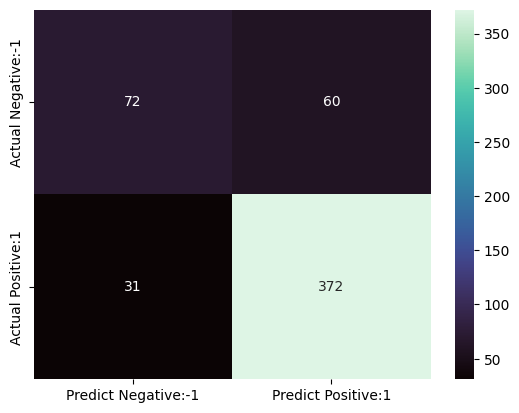

In [92]:
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [93]:
def rbf(x1, x2, gamma=1):
    """
    input:
        x1: first vector
        x2: second vector
        gamma: rbf kernel parameter with defalt value 1.
    output:
        ouput: computed rbf of two input vectors
    """
    # TODO: Write your code here
    diff = np.expand_dims(x1, 1) - np.expand_dims(x2, 0)
    output = np.exp(-gamma * np.sum(diff ** 2, axis=2))
    return output

def soft_margin_svm(X, y, C, gamma=1):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
        gamma: rbf kernel parameter with defalt value 1.
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    """

    # TODO: Write your code here

    n_samples, n_features = X.shape
    K = rbf(X, X, gamma)
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)

    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x']).flatten()

    sv = alphas > 1e-5
    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas

In [94]:
gammas = [00.1, 0.1, 1, 10, 100]
best_gamma = None
best_balanced_accuracy = 0
for gamma in gammas:
    print(gamma)
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(x_train, y_train, C=1.0, gamma=gamma)
    y_val_pred = predict_labels(x_val, support_vectors, support_vector_labels, support_vector_alphas)
    current_accuracy = balanced_accuracy_score(y_val, y_val_pred)

    if current_accuracy > best_balanced_accuracy:
        best_balanced_accuracy = current_accuracy
        best_gamma = gamma
        best_support_vectors = support_vectors
        best_support_vector_labels = support_vector_labels
        best_support_vector_alphas = support_vector_alphas

print(best_gamma)

0.1
     pcost       dcost       gap    pres   dres
 0: -3.4790e+02 -3.0276e+03  2e+04  3e+00  6e-15
 1: -2.5226e+02 -1.8732e+03  2e+03  2e-01  4e-15
 2: -2.6881e+02 -5.6277e+02  3e+02  2e-02  3e-15
 3: -3.0902e+02 -4.0282e+02  1e+02  6e-03  4e-15
 4: -3.2329e+02 -3.6636e+02  4e+01  2e-03  4e-15
 5: -3.2998e+02 -3.5053e+02  2e+01  8e-04  4e-15
 6: -3.3427e+02 -3.4086e+02  7e+00  2e-04  4e-15
 7: -3.3590e+02 -3.3763e+02  2e+00  4e-07  5e-15
 8: -3.3626e+02 -3.3709e+02  8e-01  3e-14  5e-15
 9: -3.3660e+02 -3.3665e+02  5e-02  2e-16  5e-15
10: -3.3662e+02 -3.3662e+02  1e-03  8e-15  5e-15
11: -3.3662e+02 -3.3662e+02  1e-05  8e-15  5e-15
Optimal solution found.
0.1
     pcost       dcost       gap    pres   dres
 0: -3.4790e+02 -3.0276e+03  2e+04  3e+00  6e-15
 1: -2.5226e+02 -1.8732e+03  2e+03  2e-01  4e-15
 2: -2.6881e+02 -5.6277e+02  3e+02  2e-02  3e-15
 3: -3.0902e+02 -4.0282e+02  1e+02  6e-03  4e-15
 4: -3.2329e+02 -3.6636e+02  4e+01  2e-03  4e-15
 5: -3.2998e+02 -3.5053e+02  2e+01  8e-

In [95]:
y_pred = predict_labels(np.array(x_test), best_support_vectors, best_support_vector_labels, best_support_vector_alphas)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.8018691588785046
Balanced Accuracy:  0.6978250244379276
Confusion Matrix:
 [[ 65  67]
 [ 39 364]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

In [96]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]
param_grid = {'C': Cs, 'gamma': gammas}

svc = SVC(kernel='rbf')
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_non_binary, y_train_non_binary)
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_non_binary)
accuracy = accuracy_score(y_test_non_binary, y_pred)
print("Test set accuracy: ", accuracy)
balanced_accuracy = balanced_accuracy_score(y_test_non_binary, y_pred)
print("Balanced Accuracy: ", balanced_accuracy)

Best parameters:  {'C': 10, 'gamma': 0.1}
Best cross-validation score:  0.9088310800394132
Test set accuracy:  0.925419515226849
Balanced Accuracy:  0.8963883870479835


Implement Multiclass SVM from scratch without using ready functions (optional).

In [97]:
def svm_train_rbf(X, y, C, gamma):
    n_samples, n_features = X.shape

    K = rbf(X, X, gamma)
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones((n_samples, 1)))
    G = matrix(np.vstack((np.eye(n_samples) * -1, np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(y.reshape(1, -1), tc='d')
    b = matrix(np.zeros(1))

    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    sv = alphas > 1e-5
    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    b = np.mean([y_k - np.sum(support_vector_alphas * support_vector_labels *
                              rbf(support_vectors, x_k, gamma))
                 for x_k, y_k in zip(support_vectors, support_vector_labels)])

    return support_vectors, support_vector_alphas, support_vector_labels, b


def train_one_vs_rest_svm_rbf(X, Y, C, gamma):
    classes = np.unique(Y)
    models = {}

    for c in classes:
        y_binary = np.where(Y == c, 1, -1)
        model = svm_train_rbf(X, y_binary, C, gamma)
        models[c] = model

    return models

def predict_one_vs_rest_rbf(models, X):
    n_samples = X.shape[0]
    predictions = np.zeros(n_samples)

    for i in range(n_samples):
        decision_values = {c: np.sum(alphas * labels * rbf(sv, X[i], gamma))
                           for c, (sv, alphas, labels, gamma) in models.items()}
        predictions[i] = max(decision_values, key=decision_values.get)

    return predictions


C = 10
gamma = 0.1
models = train_one_vs_rest_svm_rbf(x_train_non_binary, y_train_non_binary, C, gamma)
predictions = predict_one_vs_rest_rbf(models, x_test_non_binary)

     pcost       dcost       gap    pres   dres
 0:  1.2990e+03 -1.0160e+05  2e+05  3e-01  2e-14
 1:  1.3142e+03 -1.3397e+04  2e+04  2e-02  2e-14
 2:  4.8804e+02 -3.6784e+03  5e+03  4e-03  2e-14
 3:  9.7952e+01 -1.5367e+03  2e+03  1e-03  1e-14
 4: -4.1005e+01 -9.2145e+02  9e+02  6e-04  1e-14
 5: -1.3358e+02 -5.0203e+02  4e+02  5e-06  1e-14
 6: -1.7972e+02 -3.3091e+02  2e+02  2e-14  1e-14
 7: -1.9949e+02 -2.6355e+02  6e+01  4e-14  1e-14
 8: -2.0870e+02 -2.3596e+02  3e+01  3e-14  1e-14
 9: -2.1352e+02 -2.2415e+02  1e+01  2e-14  1e-14
10: -2.1492e+02 -2.2119e+02  6e+00  2e-14  1e-14
11: -2.1590e+02 -2.1905e+02  3e+00  4e-16  1e-14
12: -2.1669e+02 -2.1784e+02  1e+00  2e-14  1e-14
13: -2.1701e+02 -2.1735e+02  3e-01  2e-14  1e-14
14: -2.1713e+02 -2.1719e+02  6e-02  5e-15  1e-14
15: -2.1716e+02 -2.1716e+02  7e-03  4e-16  1e-14
16: -2.1716e+02 -2.1716e+02  1e-04  3e-15  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6335e+03 -8.2626e+04  2e+05  3e-01  7e-1

# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

Accuracy:  0.8657551274083282
Balanced Accuracy:  0.8244508930714288


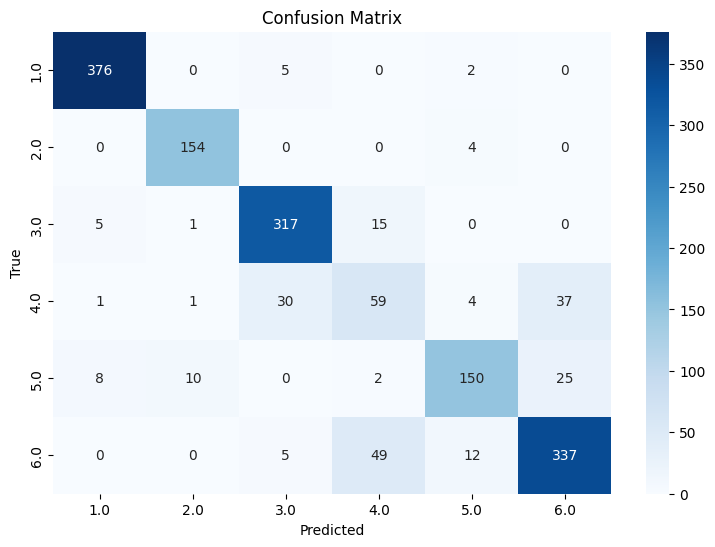

In [98]:
x_combined = np.concatenate([x_train_non_binary, x_val_non_binary], axis=0)
y_combined = np.concatenate([y_train_non_binary, y_val_non_binary], axis=0)

svc_linear = SVC(kernel='linear')
svc_linear.fit(x_combined, y_combined)
y_pred = svc_linear.predict(x_test_non_binary)
accuracy = accuracy_score(y_test_non_binary, y_pred)
print("Accuracy: ", accuracy)
balanced_accuracy = balanced_accuracy_score(y_test_non_binary, y_pred)
print("Balanced Accuracy: ", balanced_accuracy)

cm = confusion_matrix(y_test_non_binary, y_pred)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_test_non_binary), yticklabels=np.unique(y_test_non_binary))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Since it was vague what to do here, I trained the model on 75% of the data and tested on 25% of the data

### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part.

Accuracy:  0.8906152889993785
Balanced Accuracy:  0.8592437472073429


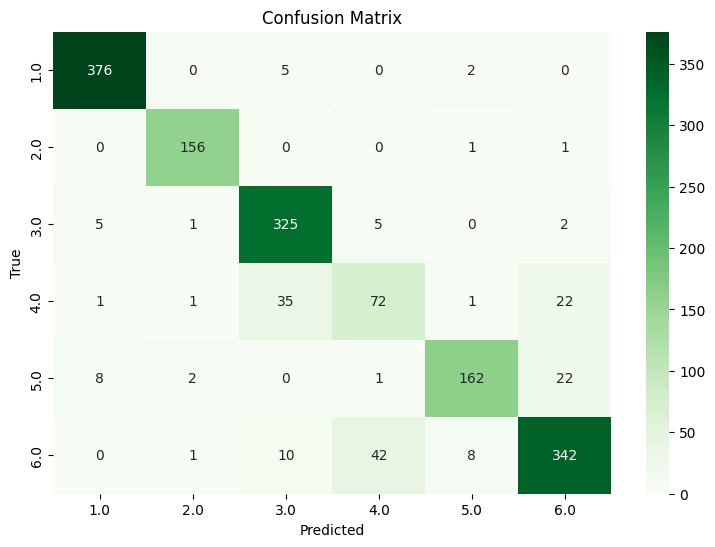

In [99]:
svc_rbf = SVC(kernel='rbf', gamma='scale')
svc_rbf.fit(x_combined, y_combined)
y_pred_rbf = svc_rbf.predict(x_test_non_binary)

accuracy_rbf = accuracy_score(y_test_non_binary, y_pred_rbf)
balanced_acc_rbf = balanced_accuracy_score(y_test_non_binary, y_pred_rbf)
print("Accuracy: ", accuracy_rbf)
print("Balanced Accuracy: ", balanced_acc_rbf)

cm_rbf = confusion_matrix(y_test_non_binary, y_pred_rbf)
plt.figure(figsize=(9, 6))
sns.heatmap(cm_rbf, annot=True, fmt="d", cmap='Greens', xticklabels=np.unique(y_test_non_binary), yticklabels=np.unique(y_test_non_binary))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy:  0.8980733374766936
Balanced Accuracy:  0.8660218846994341


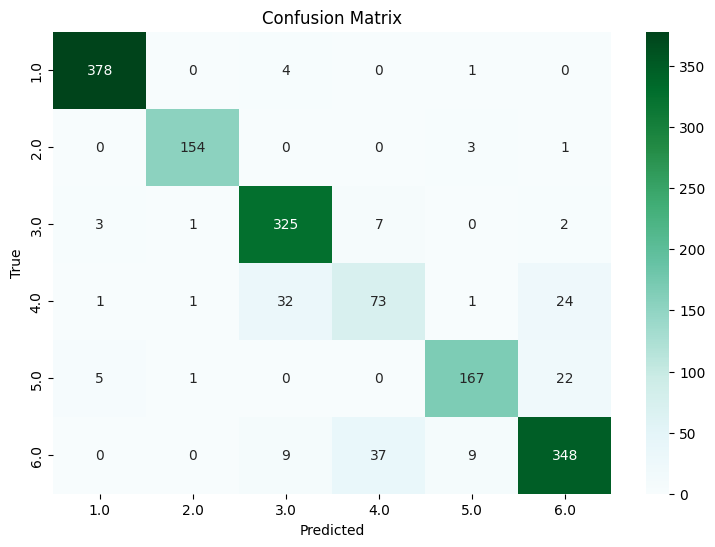

In [100]:
svc_polynomial = SVC(kernel='poly', degree=3, gamma='scale', coef0=1.0)
svc_polynomial.fit(x_combined, y_combined)
y_pred_poly = svc_polynomial.predict(x_test_non_binary)
accuracy_poly = accuracy_score(y_test_non_binary, y_pred_poly)
balanced_acc_poly = balanced_accuracy_score(y_test_non_binary, y_pred_poly)
print("Accuracy: ", accuracy_poly)
print("Balanced Accuracy: ", balanced_acc_poly)

cm_poly = confusion_matrix(y_test_non_binary, y_pred_poly)
plt.figure(figsize=(9, 6))
sns.heatmap(cm_poly, annot=True, fmt="d", cmap='BuGn', xticklabels=np.unique(y_combined), yticklabels=np.unique(y_combined))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy:  0.6861404599129894
Balanced Accuracy:  0.5801569196942854


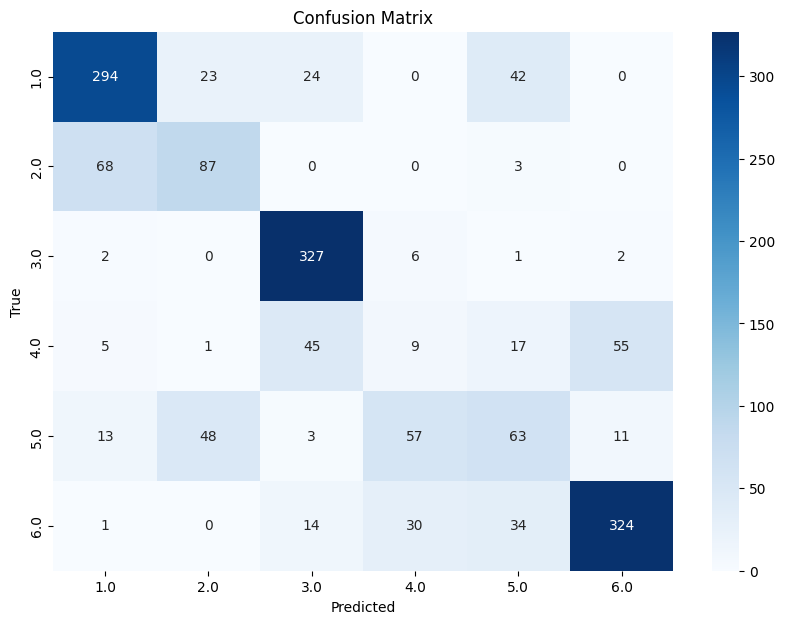

In [101]:
svc_sigmoid = SVC(kernel='sigmoid', gamma='scale', coef0=1.0)
svc_sigmoid.fit(x_val_test, y_val_test)
y_pred_sigmoid = svc_sigmoid.predict(x_test_non_binary)

accuracy_sigmoid = accuracy_score(y_test_non_binary, y_pred_sigmoid)
balanced_acc_sigmoid = balanced_accuracy_score(y_test_non_binary, y_pred_sigmoid)
print("Accuracy: ", accuracy_sigmoid)
print("Balanced Accuracy: ", balanced_acc_sigmoid)

cm_sigmoid = confusion_matrix(y_test_non_binary, y_pred_sigmoid)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_sigmoid, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_test_non_binary), yticklabels=np.unique(y_test_non_binary))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one?





`Linear kernel has good classification for the first classes, but has some misclassifications in class 4 and class 5. Gaussian kernel has very high accuracy across all classes with some small errors in 4, 5, 6 categories. Polynomial kernel has identical performance to the Gaussian kernel in both metrics and confusion matrix distribution. This suggests that the polynomial degree effectively captures the data structure, similar to the RBF kernel. Sigmoid kernel has lower performance across most classes compared to other kernels. This shows sigmoid function does not model the separations between classes well in this dataset. Linear kernel is a good choice for this dataset if we care about Speed and Simplicity with a bit lower perfomance. However, we should choose the Gaussian or Polynomial kernel for the best accuracy and handling of complex patterns in data.`